Reading an RGB image stored in my local directory/drive and displaying the image.

Text(0.5, 1.0, 'Original RGB image')

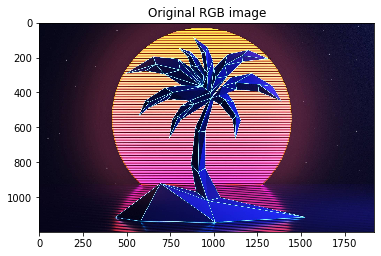

In [2]:
#1. Read and display the RGB image (png image)
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt 
img = mpimg.imread('/content/drive/My Drive/2345.png', 0) 
plt.figure()
plt.imshow(img)
plt.title('Original RGB image', fontsize = 12)

Using the 'skiimage' package we convert the RGB color scheme image into a Lab color scheme image. 
Split the Lab image into the three components (L, a and b) and display each component as a grey image.  

Text(0.5, 1.0, 'b component')

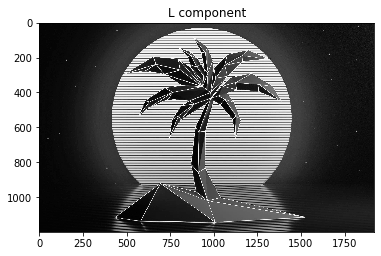

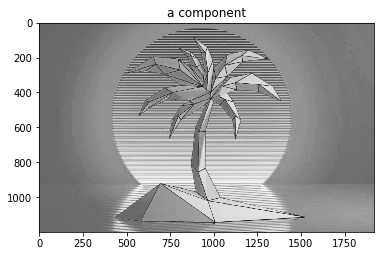

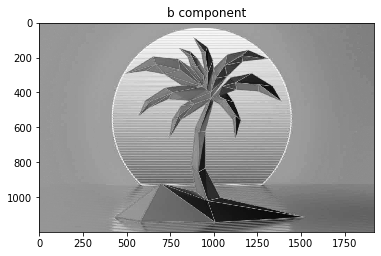

In [3]:
#2. Converting the RGB image to a Lab image and displaying each component as a grey scale image
from skimage import color
lab = color.rgb2lab(img)
L = lab[:, :, 0]
a = lab[:, :, 1]
b = lab[:, :, 2]
plt.figure()
plt.imshow(L, cmap='Greys_r')
plt.title('L component', fontsize = 12)

plt.figure()
plt.imshow(a, cmap='Greys_r')
plt.title('a component', fontsize = 12)

plt.figure()
plt.imshow(b, cmap='Greys_r')
plt.title('b component', fontsize = 12)

First we set a sigma value such that the filtered images are not too blurry.
We then create two empty arrays of the size of the L component.
Using the 'gaussian_filter' funtion from the filters package we derive the derivatives in the X and Y direction using the sigma value.

Text(0.5, 1.0, 'Gaussian derivative in the Y direction')

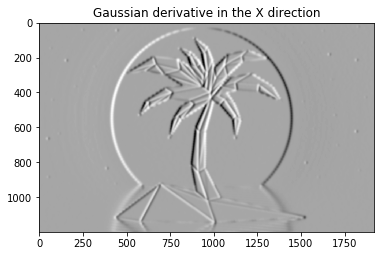

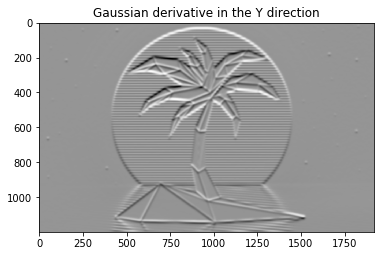

In [4]:
#3. Convolution by derivatives of Gausian filter
from scipy.ndimage import filters
sigma = 6
imx = np.zeros(L.shape)
filters.gaussian_filter(L, (sigma,sigma), (0,1), imx)
imy = np.zeros(L.shape)
filters.gaussian_filter(L, (sigma,sigma), (1,0), imy)
plt.figure()
plt.imshow(imx, cmap='Greys_r')
plt.title('Gaussian derivative in the X direction', fontsize = 12)
plt.figure()
plt.imshow(imy, cmap='Greys_r')
plt.title('Gaussian derivative in the Y direction', fontsize = 12)

Computing a 2D histogram using the a and b components of the Lab image.
First we flatten component a and b of the lab image.
We then computer the histogram, x and y edges using the numpy function 'histogram2d'. Range is mentioned from -128 to 127 as that is the range of the a and b component of the Lab image.
Total value range of a and b have 256 values from -128 to 127, so the bins value is selected as 64 (256/4) having 4 values in each bin.
We then display the histogram as a 3D bar plot.

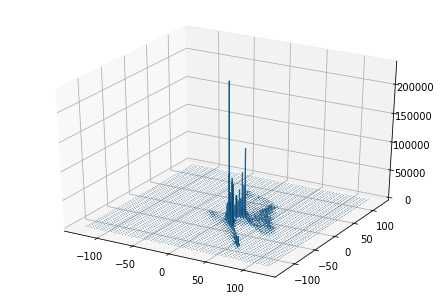

In [5]:
#4. Computing a 2D histogram and displaying it as a heat map and/or bar plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
a = lab[:, :, 1].flatten()
b = lab[:, :, 2].flatten()
hist, xedges, yedges = np.histogram2d(a, b, bins=64, range=[[-128, 127], [-128, 127]])
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = 0
dx = dy = np.ones_like(zpos)
dz = hist.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()


For back project I have considered another image to give a clear result. 

1) Load the target image and then convert it into a Lab image.
2) Load the reference image and then convert it into a Lab image.
3) We then calculate the reference image histogram using the reference Lab image as the first, [1, 2] as the a and b component as the second, 'None' as there is no reference histogram as third and value range as the fourth parameters.
4) We then calculate the mask using the target Lab image as the first, [1, 2] as a and b component as the second, reference histogram as the third and range as the fourth parameters.
5) Using the cv2 library we then perform some steps to remove the noise in the mask and make it more accurate.
6) Next we merge the mask three times so that the dimensions are equal as that of the target image having three dimensions (Lab). Once the dimensions are equal we can perform the bitwise and to get the result i.e. the mask with the original color.
7) We then display the original image, result with and without the noise removal and the reference window taken 
8) While displaying we convert the lab images back to rgb as the plt.show funtion accepts only rgb images and passing the Lab image would result in weird color combinations.


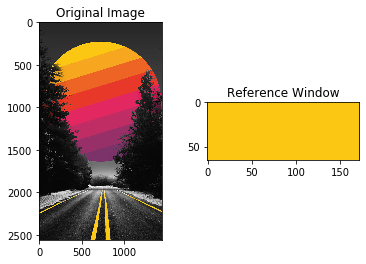

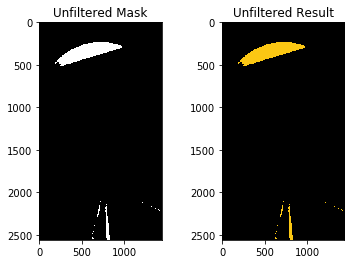

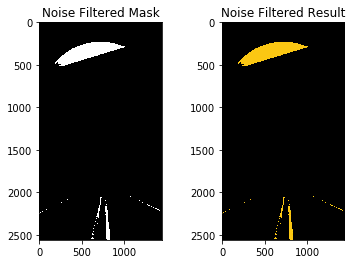

In [28]:
#5. Computing a back projection map
import cv2
from google.colab.patches import cv2_imshow

targetImage = cv2.imread('/content/drive/My Drive/road.jpg')
originalLAB = cv2.cvtColor(targetImage, cv2.COLOR_BGR2LAB)
referenceWindow = cv2.imread('/content/drive/My Drive/roadReference.jpg')
referenceLAB = cv2.cvtColor(referenceWindow, cv2.COLOR_BGR2LAB)

def calculateBackProjection(targetImage, originalLAB, referenceWindow, referenceLAB):

  referenceHist = cv2.calcHist([referenceLAB], [1, 2], None, [256, 256], [0, 180, 0, 256])
  mask = cv2.calcBackProject([originalLAB], [1, 2], referenceHist, [0, 180, 0, 256], 1)

  #Noise filtering code
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  filteredMask = cv2.filter2D(mask, -1, kernel)
  _, filteredMask = cv2.threshold(filteredMask, 100, 255, cv2.THRESH_BINARY)
  filteredMask = cv2.merge((filteredMask, filteredMask, filteredMask))
  filteredResult = cv2.bitwise_and(targetImage, filteredMask)
  
  mask = cv2.merge((mask, mask, mask))
  result = cv2.bitwise_and(targetImage, mask)
  
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGB))
  plt.title('Original Image', fontsize = 12)

  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(referenceWindow, cv2.COLOR_BGR2RGB))
  plt.title('Reference Window', fontsize = 12)

  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
  plt.title('Unfiltered Mask', fontsize = 12)

  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.title('Unfiltered Result', fontsize = 12)

  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(filteredMask, cv2.COLOR_BGR2RGB))
  plt.title('Noise Filtered Mask', fontsize = 12)

  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(filteredResult, cv2.COLOR_BGR2RGB))
  plt.title('Noise Filtered Result', fontsize = 12)
  plt.show()

calculateBackProjection(targetImage, originalLAB, referenceWindow, referenceLAB)

Taking the L component of the Lab image we compute the histogram and the cdf and display the output. Bins are selected to 100 as the range of the L component is from 0 to 100. 
Then the histogram of the L component is then equalized and is displayed with the new cdf. As seen in the output, the cdf is equalized throughout the histogram.
The image corresponding to the L component is outputted. It can be clearly seen that after equalization the image ontrast has increased and the darker areas can be seen clearly.

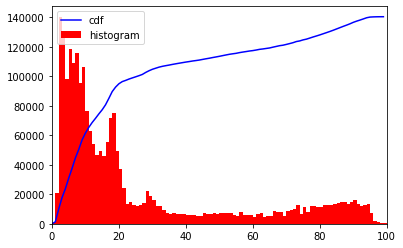

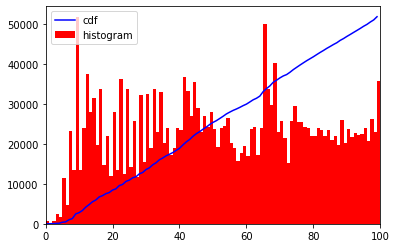

Text(0.5, 1.0, 'Equalized Image')

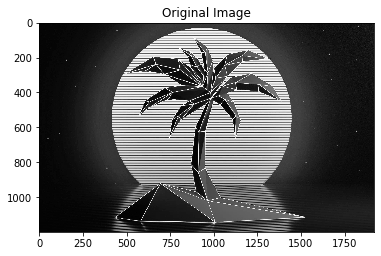

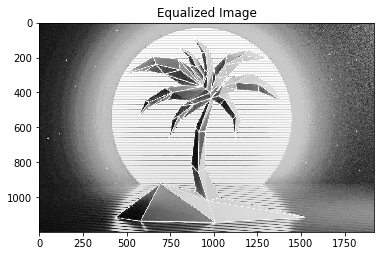

In [7]:
#6. Performing histogram equalization on the ID histogram of the luminuous component of the Lab image
import cv2
import numpy as np

def equalizeHistogram(im,bins):
  imhist,bins = np.histogram(im.flatten(),bins, [0,100])
  cdf = imhist.cumsum()
  cdf = 100 * cdf / cdf[-1]
  im2 = np.interp(im.flatten(),bins[:-1],cdf)
  return im2.reshape(im.shape)

def displayHistogram(image):
  hist,bins = np.histogram(image.flatten(),100,[0,100])
  cdf = hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()
  plt.plot(cdf_normalized, color = 'b')
  plt.hist(image.flatten(),100,[0,100], color = 'r')
  plt.xlim([0,100])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.show()

displayHistogram(L)  

L2 = equalizeHistogram(L, 100)
displayHistogram(L2)

plt.figure()
plt.imshow(L, cmap='Greys_r')
plt.title('Original Image', fontsize = 12)

plt.figure()
plt.imshow(L2, cmap='Greys_r')
plt.title('Equalized Image', fontsize = 12)

In the below section we have compared and evauated various histograms of the L component of the original image using different histogram comparing algorithms. We can clearly see each histogram (gray scale image) has different similarity values based on the method. 

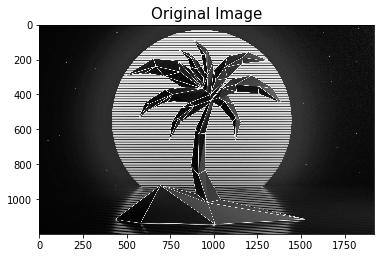

Hellinger histogram comparisson  0.0
Chi-Squared histogram comparisson  0.0
Intersection histogram comparisson  2304000.0
Correlation histogram comparisson  1.0
Alternative Chi-Square histogram comparisson  0.0




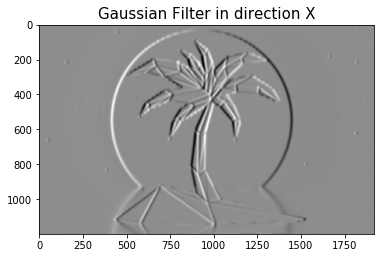

Hellinger histogram comparisson  0.8334870567865322
Chi-Squared histogram comparisson  328854028.0350826
Intersection histogram comparisson  283990.0
Correlation histogram comparisson  -0.09074070950808202
Alternative Chi-Square histogram comparisson  7589052.607922398




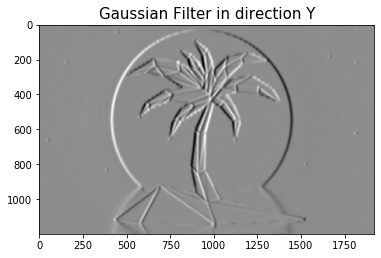

Hellinger histogram comparisson  0.8236383092414156
Chi-Squared histogram comparisson  212259488.33698216
Intersection histogram comparisson  272382.0
Correlation histogram comparisson  -0.09845146999241149
Alternative Chi-Square histogram comparisson  7575511.728744516




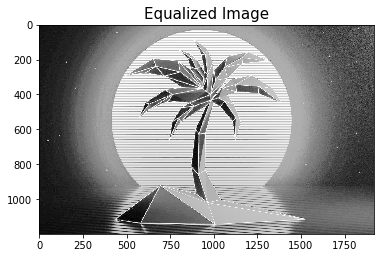

Hellinger histogram comparisson  0.469529925584486
Chi-Squared histogram comparisson  11540494.698496964
Intersection histogram comparisson  1110196.0
Correlation histogram comparisson  -0.3683373062187549
Alternative Chi-Square histogram comparisson  3088504.6493585203




In [0]:
#6. Histogram comparison and evaluation.
import cv2
 
originalImage = L
gaussianFilterX = imx
gaussianfilterY = imy
equalizedImage = L2

# Calculate the histogram and normalize it
hist_originalImage = np.histogram(originalImage.flatten(), 100)
hist_gaussianFilterX = np.histogram(gaussianFilterX.flatten(), 100)
hist_gaussianFilterY = np.histogram(gaussianfilterY.flatten(), 100)
hist_equalizedImage = np.histogram(equalizedImage.flatten(), 100)

def np_hist_to_cv(np_histogram_output):
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

def compareAndDisplayHistogram(imageName, image, hist):
  plt.title(imageName, fontsize = 15)
  plt.imshow(image, cmap='gray')
  plt.show()
  print('Hellinger histogram comparisson ', cv2.compareHist(np_hist_to_cv(hist_originalImage), np_hist_to_cv(hist), cv2.HISTCMP_BHATTACHARYYA))
  print('Chi-Squared histogram comparisson ', cv2.compareHist(np_hist_to_cv(hist_originalImage), np_hist_to_cv(hist), cv2.HISTCMP_CHISQR))
  print('Intersection histogram comparisson ', cv2.compareHist(np_hist_to_cv(hist_originalImage), np_hist_to_cv(hist), cv2.HISTCMP_INTERSECT))
  print('Correlation histogram comparisson ', cv2.compareHist(np_hist_to_cv(hist_originalImage), np_hist_to_cv(hist), cv2.HISTCMP_CORREL))
  print('Alternative Chi-Square histogram comparisson ', cv2.compareHist(np_hist_to_cv(hist_originalImage), np_hist_to_cv(hist), cv2.HISTCMP_CHISQR_ALT))
  print('')
  print('')
  print('')

compareAndDisplayHistogram('Original Image', L, hist_originalImage)
compareAndDisplayHistogram('Gaussian Filter in direction X', imx, hist_gaussianFilterX)
compareAndDisplayHistogram('Gaussian Filter in direction Y', imx, hist_gaussianFilterY)
compareAndDisplayHistogram('Equalized Image', L2, hist_equalizedImage)

Evaluation of histogram equalization, when does it work, when does it not. Given below is an example when the histogram equalization works and when it does not. As you can see when an image with certain image intensity distributions is used, the histogram equalization fails to work and the resulting image is distorted. This happens when there are some bins with excessive number of pixels.

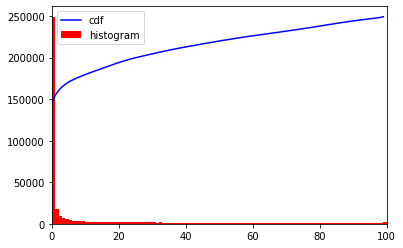

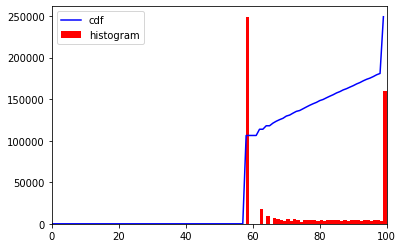

Text(0.5, 1.0, 'Equalized Image')

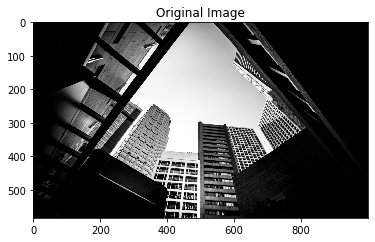

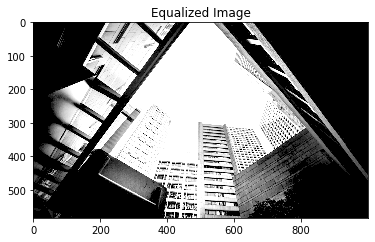

In [11]:
testHistImage = mpimg.imread('/content/drive/My Drive/tonal-cover.jpg', 0) 
displayHistogram(testHistImage)  

testHistImageEqualized = equalizeHistogram(testHistImage, 100)
displayHistogram(testHistImageEqualized)


plt.figure()
plt.imshow(testHistImage, cmap='Greys_r')
plt.title('Original Image', fontsize = 12)

plt.figure()
plt.imshow(testHistImageEqualized, cmap='Greys_r')
plt.title('Equalized Image', fontsize = 12)

Evaluation of back projection, when it works and when it does not work. As we can see the back projection fails with a blank mask and nothing is projected. On checking the a and b compoents of the Lab image, it can be see that the image color is not the same in every pixel and as a result the back projection failed.

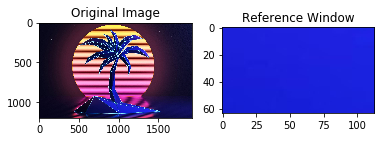

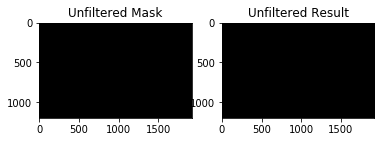

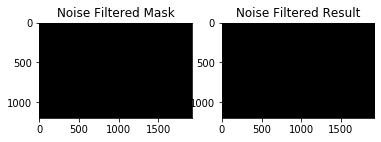

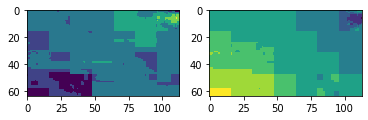

In [33]:
newTargetImage = cv2.imread('/content/drive/My Drive/2345.png')
newOriginalLAB = cv2.cvtColor(newTargetImage, cv2.COLOR_BGR2LAB)
newReferenceWindow = cv2.imread('/content/drive/My Drive/2345Reference.png')
newReferenceLAB = cv2.cvtColor(newReferenceWindow, cv2.COLOR_BGR2LAB)

calculateBackProjection(newTargetImage, newOriginalLAB, newReferenceWindow, newReferenceLAB)

plt.subplot(1,2,1)
plt.imshow(newReferenceLAB[:,:,1])
plt.subplot(1,2,2)
plt.imshow(newReferenceLAB[:,:,2])
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
